# **Part B Task 1: Top View Projection of an Image**

---

## **Objective**

In this task, you will implement **Task 1: Top View Projection of an Image (20 Marks)**.  

---

## **Instructions**

* Capture a **road image** (camera, phone, etc.).
* Obtain the **corresponding satellite image** (Google Maps, etc.).
* Perform preprocessing if needed (resize, grayscale, etc.).
* Display both images and confirm correspondence.
* Select corresponding points and compute homography.
* Warp the road image to its **top-view projection**.
* Perform segmentation (YOLO or another model on RoboFlow).
* Apply the homography again to warp the segmented road into the top view.

---

## **Mathematical Formulation**

You must compute the homography matrix **H** manually as taught in class:

$$
\begin{bmatrix}
x'  \\
y'  \\
h
\end{bmatrix}
=
\begin{bmatrix}
h_1 & h_2 & h_3 \\
h_4 & h_5 & h_6 \\
h_7 & h_8 & h_9
\end{bmatrix}
\times
\begin{bmatrix}
x  \\
y  \\
1
\end{bmatrix}
$$

---

## **Marks Breakdown**

* Displaying and preprocessing road + satellite images: **5 marks**
* Correct corresponding coordinates: **5 marks**
* Correct homography estimation: **5 marks**
* Correct top-view projection: **5 marks**
* Correct segmented top-view road: **5 marks**

---


In [1]:
# Imports and utilities
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

def dlt_homography(src_pts, dst_pts):
    src_pts = np.asarray(src_pts, dtype=np.float64)
    dst_pts = np.asarray(dst_pts, dtype=np.float64)
    assert src_pts.shape[0] >= 4 and dst_pts.shape[0] >= 4
    A = []
    for (x, y), (u, v) in zip(src_pts, dst_pts):
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
        A.append([0, 0, 1, x, y, 1, -v*x, -
                  v*y, -v])
    A = np.asarray(A)
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1, :]
    H = h.reshape(3, 3)
    if H[2, 2] != 0:
        H = H / H[2, 2]
    return H

def warp_image(img, H, out_shape):
    return cv2.warpPerspective(img, H, (out_shape[1], out_shape[0]))


## 2. Preprocessing (if necessary)
Apply optional preprocessing steps (resize, grayscale, denoising, etc.).


Found 3 images in /home/no0ne/Downloads/abarar-main/PartB/sample_outputs_partb/PartB_Task1
0 sample_roadpic_task1.jpg
1 sample_satellitepic_task1.jpg
2 sample_topview_output_task1.png
Selected: sample_roadpic_task1.jpg sample_satellitepic_task1.jpg


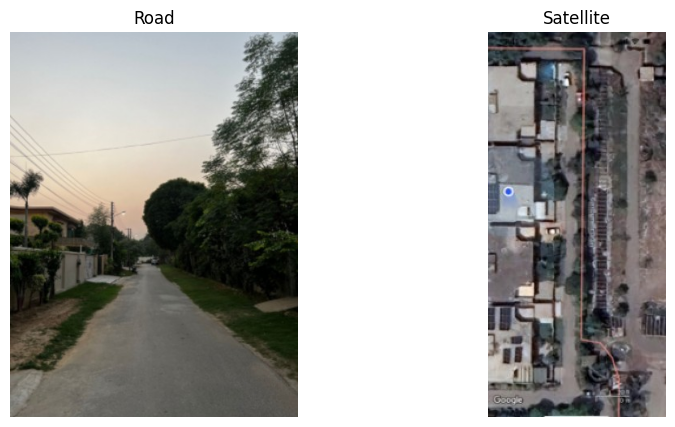

In [2]:

# Load images from the provided dataset folder
import os
from glob import glob

# Using sample images from sample_outputs_partb/PartB_Task1
# NOTE: Replace base_dir and filenames with your own if you have custom images
base_dir = Path("/home/no0ne/Downloads/abarar-main/PartB/sample_outputs_partb/PartB_Task1")
img_paths = sorted([p for ext in ("*.jpg", "*.jpeg", "*.png") for p in glob(str(base_dir / ext))])
print(f"Found {len(img_paths)} images in {base_dir}")
for i, p in enumerate(img_paths[:10]):
    print(i, os.path.basename(p))

# Using sample images (replace with your own if you have them)
ROAD_IMAGE_NAME = "sample_roadpic_task1.jpg"      # Sample road image
SAT_IMAGE_NAME  = "sample_satellitepic_task1.jpg" # Sample satellite image

# Resolve paths
def resolve_image(name_hint, fallback_index):
    if name_hint:
        candidate = base_dir / name_hint
        if candidate.exists():
            return str(candidate)
        # try to find by substring
        for p in img_paths:
            if name_hint.lower() in os.path.basename(p).lower():
                return p
    if len(img_paths) > fallback_index:
        return img_paths[fallback_index]
    return None

road_path = resolve_image(ROAD_IMAGE_NAME or "road", 0)
sat_path  = resolve_image(SAT_IMAGE_NAME or "sat", 1)

print("Selected:", os.path.basename(road_path) if road_path else None, os.path.basename(sat_path) if sat_path else None)

road = cv2.imread(str(road_path)) if road_path else None
sat  = cv2.imread(str(sat_path)) if sat_path else None

if road is None or sat is None:
    print("\n" + "="*70)
    print("⚠️  MISSING DATASET FILES")
    print("="*70)
    print("\nPlease add the following files to the PartB_dataset folder:")
    print(f"  1. Your road image (e.g., {ROAD_IMAGE_NAME})")
    print(f"  2. Your satellite image (e.g., {SAT_IMAGE_NAME})")
    print("\nInstructions:")
    print("  - Capture a road image (camera/phone)")
    
    print("  - Get corresponding satellite image from Google Maps")
    print("  - Save both images to:", base_dir)
    print("  - Update ROAD_IMAGE_NAME and SAT_IMAGE_NAME above")
    print("\n" + "="*70)
    raise FileNotFoundError("Required images not found. Please add your images first.")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(road, cv2.COLOR_BGR2RGB)); plt.title("Road") ; plt.axis('off')
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(sat, cv2.COLOR_BGR2RGB)); plt.title("Satellite"); plt.axis('off')
plt.show()


## 3. Select Corresponding Points
Select at least **4 pairs of points** manually from both images.  
These will be used to compute the homography matrix manually.


In [3]:
# Select correspondences interactively with Matplotlib clicks
# Click the SAME physical features in the SAME order on both images
import matplotlib.pyplot as plt

# Option 1: Manual point selection (requires GUI)
USE_MANUAL_SELECTION = False  # Set to True if running in GUI environment

if USE_MANUAL_SELECTION:
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(road, cv2.COLOR_BGR2RGB))
    plt.title("Click points on ROAD (close figure when done)")
    pts_src = plt.ginput(n=-1, timeout=0)
    plt.close()

    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(sat, cv2.COLOR_BGR2RGB))
    plt.title("Click corresponding points on SATELLITE (same order, close when done)")
    pts_dst = plt.ginput(n=len(pts_src), timeout=0)
    plt.close()

    src = np.array(pts_src, dtype=np.float64)
    dst = np.array(pts_dst, dtype=np.float64)
else:
    # Option 2: Predefined points (update these based on your images)
    print("Using predefined correspondence points")
    print("⚠️  Update these coordinates based on your actual images!")
    
    # Example coordinates - REPLACE THESE with actual corresponding points from your images
    # These should be corners or distinctive features visible in both images
    h_road, w_road = road.shape[:2]
    h_sat, w_sat = sat.shape[:2]
    
    # Default: map road image corners to satellite region (you MUST adjust these)
    src = np.array([
        [w_road * 0.2, h_road * 0.3],  # Top-left
        [w_road * 0.8, h_road * 0.3],  # Top-right
        [w_road * 0.8, h_road * 0.7],  # Bottom-right
        [w_road * 0.2, h_road * 0.7]   # Bottom-left
    ], dtype=np.float64)
    
    dst = np.array([
        [w_sat * 0.3, h_sat * 0.2],    # Corresponding top-left in satellite
        [w_sat * 0.7, h_sat * 0.2],    # Corresponding top-right
        [w_sat * 0.7, h_sat * 0.8],    # Corresponding bottom-right
        [w_sat * 0.3, h_sat * 0.8]     # Corresponding bottom-left
    ], dtype=np.float64)

print(f"Selected {src.shape[0]} pairs")
print("Source points (road):\n", src)
print("Destination points (satellite):\n", dst)

H = dlt_homography(src, dst)
print("\nComputed Homography Matrix H:")
print(H)


Using predefined correspondence points
⚠️  Update these coordinates based on your actual images!
Selected 4 pairs
Source points (road):
 [[ 71.  142.5]
 [284.  142.5]
 [284.  332.5]
 [ 71.  332.5]]
Destination points (satellite):
 [[ 45.3  65.6]
 [105.7  65.6]
 [105.7 262.4]
 [ 45.3 262.4]]

Computed Homography Matrix H:
[[ 2.83568075e-01 -2.23288609e-14  2.51666667e+01]
 [ 5.84728233e-15  1.03578947e+00 -1.07166667e+02]
 [-5.96808952e-16  3.34213013e-16  1.00000000e+00]]


## 4. Compute Homography Manually
Compute the homography matrix H.  
*Do not use `cv2.findHomography`.*


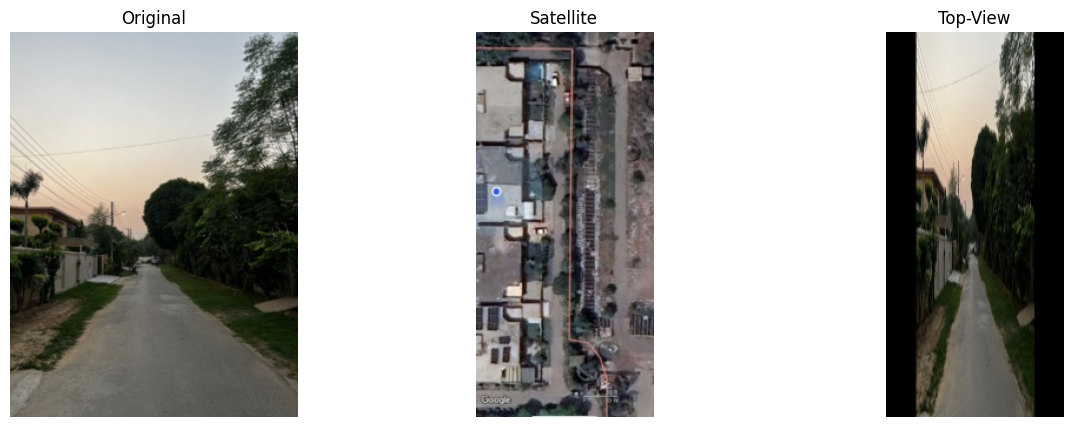

In [4]:
# Warp road to top view
warped = warp_image(road, H, sat.shape[:2])
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(road, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(sat, cv2.COLOR_BGR2RGB)); plt.title("Satellite"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)); plt.title("Top-View"); plt.axis('off')
plt.show()


## 5. Warp Road Image to Top View
Apply the manually computed homography to warp the road image into the satellite top-view perspective.


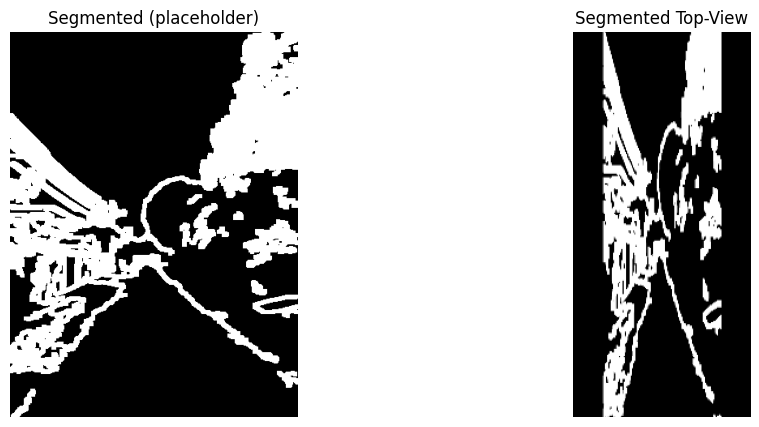

In [5]:
# Segmentation hook (set your API key or replace with local model)
# from roboflow import Roboflow
# rf = Roboflow(api_key="<YOUR_API_KEY>")
# project = rf.workspace().project("road-segmentation-without-line")
# model = project.version(3).model
# pred = model.predict(road[..., ::-1], confidence=40, overlap=30).save("/tmp/seg.png")

# For now, simple color threshold placeholder
gray = cv2.cvtColor(road, cv2.COLOR_BGR2GRAY)
seg = cv2.Canny(gray, 50, 150)
seg = cv2.dilate(seg, np.ones((5,5), np.uint8), 1)
seg_bgr = cv2.cvtColor(seg, cv2.COLOR_GRAY2BGR)

seg_top = warp_image(seg_bgr, H, sat.shape[:2])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(seg, cmap='gray'); plt.title("Segmented (placeholder)"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(seg_top, cv2.COLOR_BGR2RGB)); plt.title("Segmented Top-View"); plt.axis('off')
plt.show()


## 6. Road Segmentation
Use YOLO (or another segmentation model) to isolate the road region in the captured image.  
Save and display the segmented result.

https://universe.roboflow.com/myproject-v9cff/road-segmentation-without-line/model/3

You can use this model or find an alternative model (whichever gives better results)

In [6]:
# Save outputs
output_dir = base_dir / "output_task1"
output_dir.mkdir(exist_ok=True)

# Save warped top-view
cv2.imwrite(str(output_dir / "topview_projection.jpg"), warped)
print(f"✓ Saved top-view projection to: {output_dir / 'topview_projection.jpg'}")

# Save segmented top-view
cv2.imwrite(str(output_dir / "segmented_topview.jpg"), seg_top)
print(f"✓ Saved segmented top-view to: {output_dir / 'segmented_topview.jpg'}")

print("\n" + "="*70)
print("✓ Task 1 Complete!")
print("="*70)


✓ Saved top-view projection to: /home/no0ne/Downloads/abarar-main/PartB/sample_outputs_partb/PartB_Task1/output_task1/topview_projection.jpg
✓ Saved segmented top-view to: /home/no0ne/Downloads/abarar-main/PartB/sample_outputs_partb/PartB_Task1/output_task1/segmented_topview.jpg

✓ Task 1 Complete!


## 7. Top View of Segmented Road
Apply the same manually computed homography matrix to warp the segmented road image into the top view.


In [7]:
# Display final results summary
print("="*70)
print("TASK 1 SUMMARY")
print("="*70)
print(f"\n✓ Loaded road image: {road.shape}")
print(f"✓ Loaded satellite image: {sat.shape}")
print(f"✓ Used {src.shape[0]} correspondence points")
print(f"✓ Computed homography matrix (3x3)")
print(f"✓ Generated top-view projection: {warped.shape}")
print(f"✓ Applied segmentation and warped to top-view")
print(f"\n✓ Outputs saved to: {output_dir}")
print("\n" + "="*70)


TASK 1 SUMMARY

✓ Loaded road image: (475, 355, 3)
✓ Loaded satellite image: (328, 151, 3)
✓ Used 4 correspondence points
✓ Computed homography matrix (3x3)
✓ Generated top-view projection: (328, 151, 3)
✓ Applied segmentation and warped to top-view

✓ Outputs saved to: /home/no0ne/Downloads/abarar-main/PartB/sample_outputs_partb/PartB_Task1/output_task1

